In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Load My Mall Dataset

In [33]:
cust_details=pd.read_excel('./MyMall-DataSet.xlsx')

In [34]:
cust_details.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


In [35]:
#Renaming columns just to avoid probles due to sapce and special charectors
cust_details.columns = ['cust_id','gender','age','annual_income','spending_score']

### Finding Dstribution of 
  - Age 
  - Annual Income 
  - Spending Score 

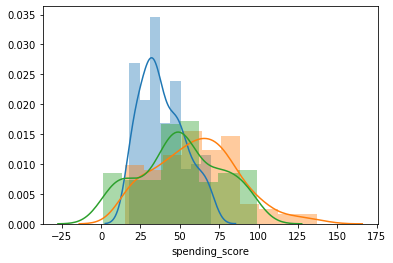

In [36]:
sns.distplot(cust_details['age'])
sns.distplot(cust_details['annual_income'])
sns.distplot(cust_details['spending_score'])

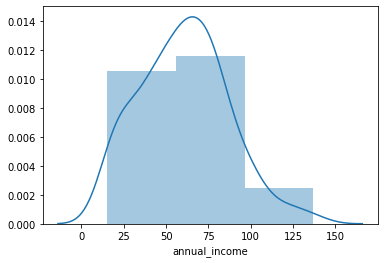

In [37]:
# Anumal Income - convert numeric to categorical (High, Medium, Low)
sns.distplot(cust_details['annual_income'], bins=3)

In [38]:
bins = [0, 50, 80, np.inf]
names = ['Low', 'Medium', 'High']
cust_details['annual_income_cat'] = pd.cut(cust_details['annual_income'], bins, labels=names)

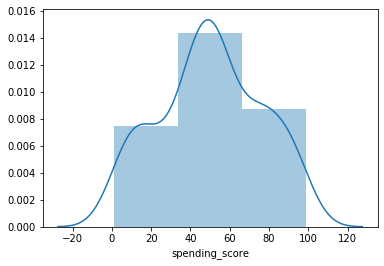

In [39]:
# Spending Score - convert numeric to categorical (High, Medium, Low)
sns.distplot(cust_details['spending_score'], bins=3)

In [40]:
bins = [0, 40, 60, np.inf]
names = ['Low', 'Medium', 'High']
cust_details['spending_score_cat'] = pd.cut(cust_details['spending_score'], bins, labels=names)

In [41]:
cust_details.head(3)

,cust_id,gender,age,annual_income,spending_score,annual_income_cat,spending_score_cat
0,1,Male,19,15,39,Low,Low
1,2,Male,21,15,81,Low,High
2,3,Female,20,16,6,Low,Low


In [42]:
cust_dim = spark.createDataFrame(cust_details)